# human cases vs. circulation times

How do the number of human tips in a cluster relate to the length of time that cluster has circulated? This notebook is for answering that question across the posterior set of trees. 

In this notebook, I am running Gytis's subtree function on every tree in the posterior. This takes a really long time, but I couldn't figure out a faster way to do it. Then, within each subtree that is pulled out, I am calculating the difference between the root of that subtree (i.e., the time of the introduction), and the date of the latest sampled tip. I am also collecting the total number of human tips per introduction. In this notebook, I am looking at persistence times of lineages introduced into domestic birds. To keep traversing, the tips encountered can be human or domestic bird, but a transition back into wild bird will stop thee traverse. 

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import time
from io import StringIO

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [4]:
def get_taxa_lines(tree_path):    
    # write out a temp tree file
#     temp_tree = tree_path.replace(".trees",".temp.tree")
#     with open(temp_tree, "w") as outfile: 
#         outfile.write("")

    lines_to_write = ""
    with open(tree_path, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [5]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [6]:
"""enumerate host transitions on the tree"""

def retrieve_subtrees(tree, trait, target_host, stop_state):
    
    traitName=trait

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={target_host:[]}
    subtype_trees={target_host:[]}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName].lower().replace(" ","_")   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName].lower().replace(" ","_")     # kploc = trait of parental node
        else:
            kploc='ancestor'

        ## if states do not match and the child is the target host
        if kloc!=kploc and kloc == target_host:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName].lower().replace(" ","_") in stop_state     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=tree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                if kloc in subtype_trees:
                    subtype_trees[kloc].append((kploc,subtree))
                else:
                    pass
                    
    return(subtype_trees)

In [7]:
def output_cluster_times(subtype_trees, traitName):
    cluster_times = {}
    
    for deme in subtype_trees: 
        cluster_times = {}
        subtree_number = 0
        
        for subtree in subtype_trees[deme]:
            subtree_number += 1
            dates = []
            hosts = []
            tips = []
            trans_from = subtree[0]
            tree = subtree[1]
            
            # pull out root time and add to dates list 
            subtree_root_date = tree.root.absoluteTime
            dates.append(subtree_root_date)
            
            for k in tree.Objects: 
                if k.branchType == "leaf":
                    # pull the date
                    date = float(k.name.split("|")[1])
                    host = k.traits[traitName]
                    hosts.append(host)
                    tips.append(k.name)
                    
                elif k.branchType == "node":
                    date = k.absoluteTime
                dates.append(date)
                
            minimum_date = min(dates)
            maximum_date = max(dates)
            date_range = maximum_date - minimum_date
            
            n_human_tips = hosts.count("human")
            
            cluster_times[subtree_number] = {"circulation_time":date_range, "n_human_tips":n_human_tips, "tips_in_subtree":tips}

    return(cluster_times)

In [8]:
def plot_exploded_tree(subtype_trees, width, height, traitName, deme, labels):
    
    color_dict = {"human":human_color, "domestic":domestic_color, "wild":wild_color, "ancestor":"grey"}#,
#                  "Southeast_Asia":"#4274CE","North_America":"#E39B39", "South_America":"#4042C7", 
#                    "China":"#E56C2F","South_Asia":"#88BB6C", "Africa":"#CEB541", "West_Asia":"#ADBD51", 
#                    "Japan_Korea":"#69B091", "Europe":"#4042C7"}
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    branchWidth=1.25 ## default branch width
    tipSize = 15
    origin_size=50

    mpl.rcParams['font.size']=16
    cumulative_y=0

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(1990,2030,5): 
        dates.append(i)
    #[ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]

    for subtree in reversed(subtype_trees[deme]): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            c = color_dict[k.traits[traitName]]
            s = tipSize
            #a = k.traits[traitName+".prob"]
 
            if k.branchType == "leaf":
                #region = k.name.split("|")[4]
                #c = color_dict[region]
                ax1.scatter(x,y,s=tipSize,facecolor=c, edgecolor="black",zorder=100) ## plot tip circle
                ax1.scatter(x,y,s=tipSize,facecolor="black", edgecolor="black",zorder=99)
                
                if labels == "yes":
                    label = k.name.split("|")[0]
                    ax1.text(x+0.3,y,label, fontsize=4,zorder=13)
                else:
                    pass
                              
            elif k.branchType == "node": 
                #c = "black"
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
#                 if xp >= cutoff:
                #c = "black"
                ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
#                 else:
#                     ax1.plot([xp,cutoff],[y,y],":",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
#                     ax1.plot([cutoff,x],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = color_dict[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
             
        # plot dotted line connecting circle to tree 
#         if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
#             ax1.plot([min_node_x,oriX],[oriY,oriY], ":", color=c,lw=branchWidth,zorder=98)

#         elif oriX < cutoff: # partly before 2016, partial dotteds
#             ax1.plot([min_node_x,cutoff],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
#             ax1.plot([cutoff,oriX],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)

#         else:
        ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in color_dict:
        marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[0, 0.12], loc=3, prop={'size': 16}, facecolor='w')

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates)
    #ax1.set_xticklabels(dates, fontsize=14)
    #ax1.axes.get_xaxis().set_ticks([])

    plt.show()

In [9]:
def run_on_trees(trees_file, trait, target_host, stop_state):
    
    start_time = time.time()
    output_dict = {}

    with open(trees_file, "r") as infile:

        tree_counter = 0
        trees_processed = 0

        for line in infile:
            if 'tree STATE_' in line:
                tree_counter += 1
                
                #if tree_counter < 2:
                if tree_counter > burnin:
                    trees_processed += 1
                    temp_tree = StringIO(taxa_lines + line)
                    tree = bt.loadNexus(temp_tree)
                    #tree.setAbsoluteTime(date_most_recent_tip) # setting this actually sort of messes up the subtrees timing
                    
                    # enumerate subtrees 
                    subtype_trees = retrieve_subtrees(tree, trait, target_host, stop_state)
                    #print(subtype_trees)
                    cluster_times = output_cluster_times(subtype_trees, trait)
                    output_dict[tree_counter] = cluster_times
                    #print(cluster_times)

    # print the amount of time this took
    total_time_seconds = time.time() - start_time
    total_time_minutes = total_time_seconds/60
    total_time_hours = total_time_minutes/60
    print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes", total_time_hours," hours) to run on", trees_processed, "trees")
    return(output_dict)

In [10]:
def convert_to_dataframe(cluster_times_dict):
    
    df = pd.DataFrame()
    for c in cluster_times_dict: 
        tree_number = c
        for subtree_number in cluster_times_dict[tree_number]:
            circulation_time = cluster_times_dict[tree_number][subtree_number]["circulation_time"]
            n_human_tips = cluster_times_dict[tree_number][subtree_number]["n_human_tips"]
            tips_in_subtree = cluster_times_dict[tree_number][subtree_number]["tips_in_subtree"]

            local_df = pd.DataFrame({"tree_number":[tree_number],"subtree_number":[subtree_number],
                                        "circulation_time":[circulation_time],"n_human_tips":[n_human_tips],
                                    "tips_in_subtree":[tips_in_subtree]})
            df = df.append(local_df)

    return(df)

## Run on trees file

In [11]:
# trees file paths
constant_human_on = {"label": "constant-human-on","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/with-human-mig/3deme-mascot-constant-with-human-mig-2021-03-15.combined.trees"}
constant_human_off = {"label": "constant-human-off","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/3deme-mascot-constant-no-human-mig-2021-03-15.combined.trees"}
skyline_human_on =  {"label": "skyline-human-on", "mig_direction":"forwards in time",
                     "trees": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/with-human-mig/2021-04-27-mascot-3deme-skyline-with-human-mig.combined.trees"}
skyline_human_off = {"label": "skyline-human-off", "mig_direction":"forwards in time",
                     "trees": "beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-muts-trees-2021-08-23.muts.trees"}

In [12]:
to_run = skyline_human_off

trees_file_path = to_run['trees']
label = to_run['label']

burnin_percent = 0

In [13]:
all_trees = trees_file_path
burnin_percent = 0

taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


0


In [14]:
# this actual trees file has 3641 trees in it; at 17 seconds per tree, this would run for 17 hours for all of them

trait = 'typeTrait'  # for the trees file, this should be typeTrait, for the mcc tree it is "max"
target_host = "domestic"
stop_state = ["domestic","human"]  # the stop state is the list of hosts for which we will continue traversing to produce a subtree; here, we want to traverse within poultry while also including human tips 

cluster_times = run_on_trees(all_trees, trait, target_host, stop_state)

this took 39031.71004104614 seconds ( 650.5285006841024  minutes 10.842141678068373  hours) to run on 3641 trees


In [15]:
#cluster_times

In [16]:
df = convert_to_dataframe(cluster_times)
print(len(df))
df.head()

518358


,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree
0,1,1,2.518589,2,[A/Chicken/HongKong/786/1997|1997.0|1997-XX-XX...
0,1,2,0.607684,0,[A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|Av...
0,1,3,1.901901,0,[A/duck/Guangxi/07/1999|1999.0|1999-XX-XX|Avia...
0,1,4,0.447087,0,[A/Goose/HongKong/3853/2000|2000.0|2000-XX-XX|...
0,1,5,0.657898,0,[A/Goose/HongKong/761/2001|2001.0|2001-XX-XX|A...


In [17]:
# write out to tsv
path = to_run['trees'].replace(".trees","-circulation-time-vs-human-tips-"+current_date+".tsv")
df.to_csv(path, sep="\t")

In [26]:
# read dataframe back in 
nonzero = pd.read_csv("beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-muts-trees-2021-08-23.muts-non-zero-circulation-time-vs-human-tips-2022-03-30.tsv", sep="\t")

In [2]:
nonzero = df[df['circulation_time'] > 0]
print(len(df1))

NameError: name 'df' is not defined

In [28]:
nonzero.head()

,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree
0,0,1,1,2.518589,2,['A/Chicken/HongKong/786/1997|1997.0|1997-XX-X...
1,0,1,2,0.607684,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...
2,0,1,3,1.901901,0,['A/duck/Guangxi/07/1999|1999.0|1999-XX-XX|Avi...
3,0,1,4,0.447087,0,['A/Goose/HongKong/3853/2000|2000.0|2000-XX-XX...
4,0,1,5,0.657898,0,['A/Goose/HongKong/761/2001|2001.0|2001-XX-XX|...


In [32]:
nonzero_first_1000_trees = nonzero[nonzero["tree_number"] <= 1000]

print(len(nonzero_first_1000_trees))
nonzero_first_1000_trees.head()

142149


,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree
0,0,1,1,2.518589,2,['A/Chicken/HongKong/786/1997|1997.0|1997-XX-X...
1,0,1,2,0.607684,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...
2,0,1,3,1.901901,0,['A/duck/Guangxi/07/1999|1999.0|1999-XX-XX|Avi...
3,0,1,4,0.447087,0,['A/Goose/HongKong/3853/2000|2000.0|2000-XX-XX...
4,0,1,5,0.657898,0,['A/Goose/HongKong/761/2001|2001.0|2001-XX-XX|...


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)



Call:
lm(formula = circulation_time ~ n_human_tips, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-23.8751  -0.7157  -0.4463   0.1451  16.0055 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.8756346  0.0037504   233.5   <2e-16 ***
n_human_tips 0.3394833  0.0008677   391.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.385 on 142147 degrees of freedom
Multiple R-squared:  0.5185,	Adjusted R-squared:  0.5185 
F-statistic: 1.531e+05 on 1 and 142147 DF,  p-value: < 2.2e-16



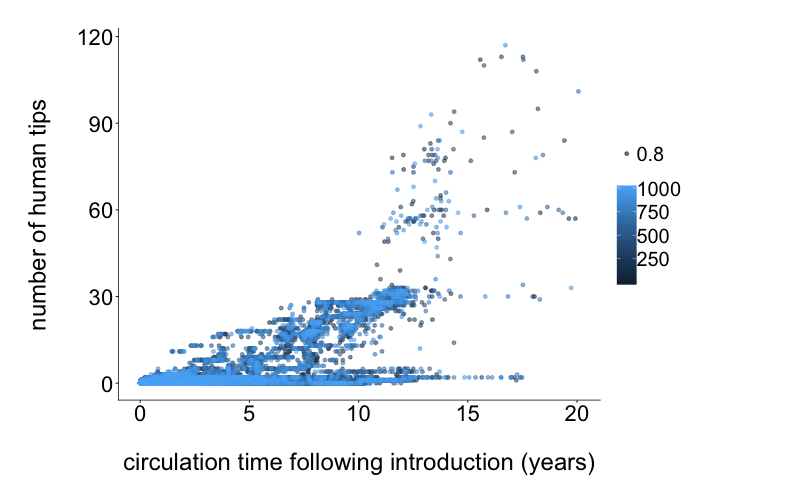

In [33]:
%%R -w 800 -h 500 -u px -i nonzero_first_1000_trees,label,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

df <- nonzero_first_1000_trees

reg1 <- lm(circulation_time~n_human_tips,data=df) 
print(summary(reg1))

output_filename = paste("circulation-time-vs-human-tips-full-",current_date,".pdf", sep="")

p <- ggplot(data=df, aes(x=circulation_time, y=n_human_tips, color=tree_number, alpha = 0.8)) + 
    geom_point()+
    labs(x="\ncirculation time following introduction (years)", y="number of human tips\n")+
#      scale_y_continuous(breaks=seq(0,40,5), limits=c(0,40))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [34]:
# let's look separately at clusters with 0 and >0 human tips 
no_human_tips = nonzero[nonzero["n_human_tips"] == 0]
some_human_tips = nonzero[nonzero["n_human_tips"] > 0]

print(len(no_human_tips), len(some_human_tips))

428056 90302


In [35]:
long_no_human = no_human_tips[no_human_tips['circulation_time'] >= 5]
print(len(long_no_human))
long_no_human.head()

5399


,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree
21,0,1,22,9.514521,0,['A/chicken/Vietnam/NCVD-swab276/2008|2008.915...
50,0,1,51,9.637710,0,['A/duck/EasternChina/108/2008|2008.954|2008-1...
150,0,2,23,8.180612,0,['A/chicken/Vietnam/NCVD-swab276/2008|2008.915...
184,0,2,57,7.704275,0,['A/duck/EasternChina/108/2008|2008.954|2008-1...
329,0,3,50,9.465875,0,['A/duck/EasternChina/108/2008|2008.954|2008-1...


In [39]:
long_no_human_clusters = long_no_human['tips_in_subtree']
print(len(long_no_human_clusters))
print(len(set(long_no_human_clusters)))

5399
259


In [42]:
short_some_human = some_human_tips[some_human_tips['circulation_time'] < 1]
print(len(short_some_human))

31614


In [43]:
print(len(short_some_human[short_some_human['n_human_tips'] > 1]))
short_some_human_clusters = short_some_human[short_some_human['n_human_tips'] > 1]['tips_in_subtree']

print(len(set(short_some_human_clusters)))

1632
106


In [44]:
print(short_some_human_clusters)

1307      ['A/duck/Vietnam/TG24/2005|2005.485|2005-06-27...
1315      ['A/Hubei/1/2006|2006.247|2006-04-01|Human|Chi...
2389      ['A/chicken/Sharkeya/14209SS/2014|2014.975|201...
3159      ['A/turkey/Menia/15248S/2015|2015.153|2015-02-...
3241      ['A/Sichuan/2/2006|2006.025|2006-01-10|Human|C...
3882      ['A/Guangxi/1/2005|2005.893|2005-11-23|Human|C...
4727      ['A/HongKong/5923/2012|2012.404|2012-05-28|Hum...
6175      ['A/HongKong/5923/2012|2012.404|2012-05-28|Hum...
6207      ['A/chicken/Sharkeya/14209SS/2014|2014.975|201...
6284      ['A/Guangxi/1/2005|2005.893|2005-11-23|Human|C...
6625      ['A/Hubei/1/2006|2006.247|2006-04-01|Human|Chi...
7357      ['A/Indonesia/175H/2005|2005.86|2005-11-11|Hum...
7418      ['A/HongKong/5923/2012|2012.404|2012-05-28|Hum...
7545      ['A/Cambodia/W0112303/2012|2012.025|2012-01-10...
8496      ['A/Egypt/MOH-NRC-7271/2014|2014.901|2014-11-2...
8989      ['A/Egypt/N01400/2012|2012.194|2012-03-12|Huma...
9508      ['A/Hubei/1/2006|2006.247|2006

Maybe the best and H5N1 virus can do is be around for a long time, with a little bit of ability to infect people. But there are some that are just not able to, regardless of how long they circulate. 